# Overview
Classifying homologues groups in terms of their composition:
- Singletons
- Multigene families
    + Orthologs
    + Expanded families without inparalogs
    + Groups with inparalogs
    + Groups out of analyses (i.e., with inparalogs and two species)

# Classifying

In [1]:
import glob
import pandas as pd

In [2]:
inparalogs_group_composition = pd.read_csv('../results/misc/inparalogs_group_composition_final.tsv', sep ='\t')

In [3]:
import os
import glob
from Bio import SeqIO
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

# Function to classify a single homolog group and count genes
def classify_homolog_group(filepath, inparalog_species_set, species_prefix_length=4):
    # Parse the FASTA file
    sequences = [record for record in SeqIO.parse(filepath, "fasta")]
    family_code = filepath.rpartition('/')[2].rpartition('.')[0]
    
    # Count the number of sequences and species present
    species_counts = defaultdict(int)
    for seq in sequences:
        species = seq.id.split('.')[0]
        species_counts[species] += 1
    
    num_sequences = len(sequences)
    num_species = len(species_counts)

    # Classification pipeline
    if num_sequences == 1:
        return (family_code, "Singleton", "Singleton", num_sequences)
    
    if num_sequences == num_species:
        return (family_code, "Multigene family", "One-to-one orthologs family", num_sequences)
    
    if num_species == 1:
        return (family_code, "Multigene family", "Unispecies family", num_sequences)
    
    if family_code in inparalog_species_set:
        return (family_code, "Multigene family", "Multispecies family (inparalogs detected)", num_sequences)
    
    if num_species == 2 and num_sequences == 3:
        return (family_code, "Multigene family", "Multispecies family (ambiguous, not studied)", num_sequences)

    return (family_code, "Multigene family", "Multispecies family (No inparalogs detected)", num_sequences)

# Load inparalogs table
inparalogs_df = pd.read_csv('../results/misc/inparalogs_group_composition_final.tsv', sep='\t')

# Generate a non-redundant set of species with monophyletic group codes
inparalog_species_set = set(inparalogs_df['monophyletic_group_code'].str.split('_').str[0])

# Get the list of FASTA files
fasta_files = glob.glob('../results/homolog_groups/*.faa')

# Use ThreadPoolExecutor for parallel processing
results = []
with ThreadPoolExecutor(max_workers=32) as executor:
    futures = [executor.submit(classify_homolog_group, filepath, inparalog_species_set) for filepath in fasta_files]
    for future in futures:
        results.append(future.result())

# Convert results to a DataFrame
classification_df = pd.DataFrame(results, columns=["family_code", "classification", "specific_classification", "gene_count"])

In [4]:
classification_df.head()

,family_code,classification,specific_classification,gene_count
0,F111669,Multigene family,One-to-one orthologs family,2
1,F94361,Singleton,Singleton,1
2,F129360,Multigene family,One-to-one orthologs family,2
3,F86814,Singleton,Singleton,1
4,F79128,Singleton,Singleton,1


Just a small check...

In [5]:
len(set(classification_df.family_code.to_list())) == len(glob.glob('../results/homolog_groups/*.faa'))

True

In [6]:
set(classification_df.specific_classification.to_list())

{'Multispecies family (No inparalogs detected)',
 'Multispecies family (ambiguous, not studied)',
 'Multispecies family (inparalogs detected)',
 'One-to-one orthologs family',
 'Singleton',
 'Unispecies family'}

In [7]:
# save table
classification_df.to_csv('../results/misc/homologues_group_classification.tsv', sep ='\t', index = False)

In [8]:
classification_df = pd.read_csv('../results/misc/homologues_group_classification.tsv', sep ='\t')

# Plotting

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

## Family counts

In [39]:
classification_df.head()

,family_code,classification,specific_classification,gene_count
0,F111669,Multigene family,One-to-one orthologs family,2
1,F94361,Singleton,Singleton,1
2,F129360,Multigene family,One-to-one orthologs family,2
3,F86814,Singleton,Singleton,1
4,F79128,Singleton,Singleton,1


(0.0, 138276.6, -0.1375, 0.1375)

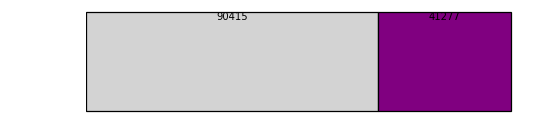

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data = classification_df

# Calculate overall counts
overall_counts = data['classification'].value_counts()

# Create the horizontal stacked bar plot
fig, ax1 = plt.subplots(figsize=(8, 2))
bar1 = ax1.barh(['Classifications'], overall_counts['Singleton'], color='lightgray', label='Singletons', height=0.25, linewidth = 1.25, edgecolor = 'black')
bar2 = ax1.barh(['Classifications'], overall_counts['Multigene family'], left=overall_counts['Singleton'], color='purple', label='Multigene families', height=0.25, linewidth = 1.25, edgecolor = 'black')

# Add text above bars
ax1.text(bar1[0].get_width() / 2, bar1[0].get_y() + bar1[0].get_height() / 2 + 0.1, f'{overall_counts["Singleton"]}', va='bottom', ha='center', color='black')
ax1.text(bar1[0].get_width() + bar2[0].get_width() / 2, bar2[0].get_y() + bar2[0].get_height() / 2 + 0.1, f'{overall_counts["Multigene family"]}', va='bottom', ha='center', color='black')

# Remove axes
ax1.axis('off')
#plt.show()


In [53]:
fig.savefig('../results/figures/figure1a.svg', format = 'svg')

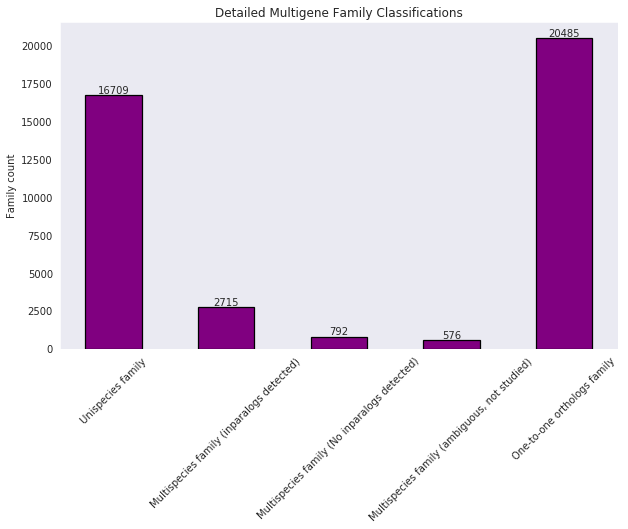

In [54]:
sns.set_style("dark")

# Filter and order the Multigene classification data
multigene_data = classification_df[classification_df['classification'] == 'Multigene family']
category_order = [
    'Unispecies family',
    'Multispecies family (inparalogs detected)',
    'Multispecies family (No inparalogs detected)',
    'Multispecies family (ambiguous, not studied)',
    'One-to-one orthologs family'
]

# Aggregate family counts for each category and ensure order
family_counts = multigene_data['specific_classification'].value_counts().reindex(category_order).fillna(0).reset_index()
family_counts.columns = ['specific_classification', 'count']

# Ensure correct ordering
family_counts['order'] = family_counts['specific_classification'].apply(lambda x: category_order.index(x))
family_counts = family_counts.sort_values('order')

# Create the vertical bar plot
fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(family_counts['specific_classification'], family_counts['count'], color='purple', width=0.5, linewidth = 1.25, edgecolor = 'black')

# Add counts above bars
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Remove grid lines and adjust labels
ax2.grid(visible=False)
ax2.set_xticks(range(len(family_counts['specific_classification'])))
ax2.set_xticklabels(family_counts['specific_classification'], rotation=45)
ax2.set_title('Detailed Multigene Family Classifications')
ax2.set_ylabel('Family count')
plt.show()

In [55]:
fig.savefig('../results/figures/figure1b.svg', format = 'svg')

## Gene counts

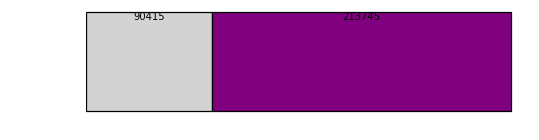

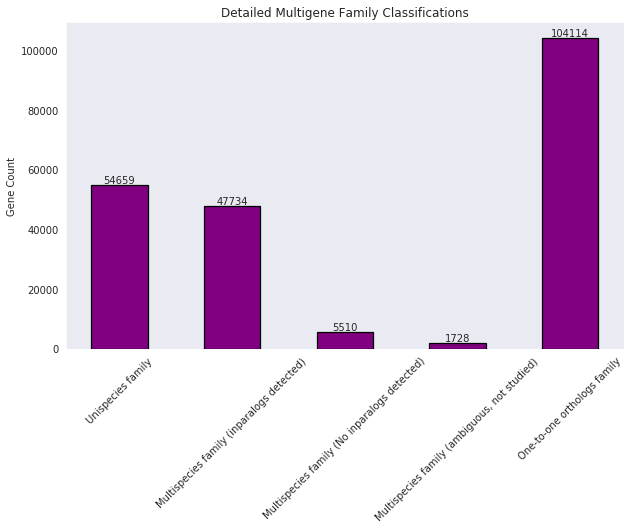

In [56]:
import matplotlib.pyplot as plt

# Calculate overall gene counts for the horizontal plot
overall_gene_counts = classification_df.groupby('classification')['gene_count'].sum()

# Create the horizontal stacked bar plot
fig, ax1 = plt.subplots(figsize=(8, 2))
bar1 = ax1.barh(['Classifications'], overall_gene_counts['Singleton'], color='lightgray', label='Singletons', height=0.25, linewidth = 1.25, edgecolor = 'black')
bar2 = ax1.barh(['Classifications'], overall_gene_counts['Multigene family'], left=overall_gene_counts['Singleton'], color='purple', label='Multigene families', height=0.25, linewidth = 1.25, edgecolor = 'black')

# Add text above bars
ax1.text(bar1[0].get_width() / 2, bar1[0].get_y() + bar1[0].get_height() / 2 + 0.1, f'{overall_gene_counts["Singleton"]}', va='bottom', ha='center', color='black')
ax1.text(bar1[0].get_width() + bar2[0].get_width() / 2, bar2[0].get_y() + bar2[0].get_height() / 2 + 0.1, f'{overall_gene_counts["Multigene family"]}', va='bottom', ha='center', color='black')

# Remove axes
ax1.axis('off')
fig.savefig('../results/figures/figure1c.svg', format = 'svg')
plt.show()

# For the detailed Multigene classifications
category_order = [
    'Unispecies family',
    'Multispecies family (inparalogs detected)',
    'Multispecies family (No inparalogs detected)',
    'Multispecies family (ambiguous, not studied)',
    'One-to-one orthologs family'
]

# Aggregate gene counts for each category
multigene_aggregate = classification_df[classification_df['classification'] == 'Multigene family'].groupby('specific_classification')['gene_count'].sum().reindex(category_order).fillna(0)

# Create the vertical bar plot
fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(multigene_aggregate.index, multigene_aggregate, color='purple', width=0.5, linewidth = 1.25, edgecolor = 'black')

# Add counts above bars
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Remove grid lines and adjust labels
ax2.grid(visible=False)
ax2.set_xticks(range(len(multigene_aggregate.index)))
ax2.set_xticklabels(multigene_aggregate.index, rotation=45)
ax2.set_title('Detailed Multigene Family Classifications')
ax2.set_ylabel('Gene Count')
fig.savefig('../results/figures/figure1d.svg', format = 'svg')
plt.show()
